# **Sales predictions**

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(os.getcwd()+"/data/train.csv")
oil = pd.read_csv(os.getcwd()+"/data/oil.csv")
stores = pd.read_csv(os.getcwd()+"/data/stores.csv")
transactions = pd.read_csv(os.getcwd()+"/data/transactions.csv")
holidays = pd.read_csv(os.getcwd()+"/data/holidays_events.csv")


## **df test split**

In [3]:
df.tail(5)

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [4]:
df["date"] = pd.to_datetime(df["date"])

In [5]:
splitDate = df.loc[len(df)-1,"date"] - timedelta(days=15)

In [6]:
test = df.loc[df.date > splitDate]
test.to_csv('created_test.csv')

In [7]:
train = df.loc[df.date <= splitDate]
train.to_csv('created_train.csv')

In [8]:
(train.date.min(),train.date.max()),(test.date.min(),test.date.max())

((Timestamp('2013-01-01 00:00:00'), Timestamp('2017-07-31 00:00:00')),
 (Timestamp('2017-08-01 00:00:00'), Timestamp('2017-08-15 00:00:00')))

###  **Testing if there are holidays in the test data**

In [9]:
train["month-date"] = train.date.dt.strftime("%m-%d")

### **Testing how much they affect sales**

In [10]:
train["month-date"] = train.date.dt.strftime("%m-%d")

In [11]:
train.groupby(by="month-date")["sales"].mean()

month-date
01-01      5.881391
01-02    496.504022
01-03    451.417235
01-04    445.349347
01-05    405.070438
            ...    
12-27    406.860374
12-28    422.909732
12-29    426.289025
12-30    524.942767
12-31    480.541454
Name: sales, Length: 365, dtype: float64

<Axes: xlabel='month-date'>

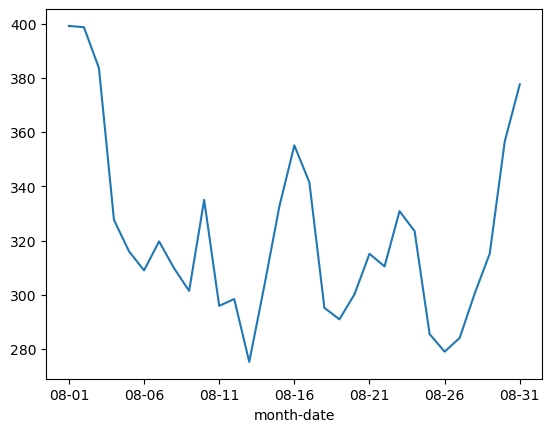

In [12]:
grouped = train.loc[(train.date.dt.month ==8)].groupby(by="month-date")["sales"].mean()

grouped.plot()

### **Holidays in august** 

In [13]:
holidays["date"] = pd.to_datetime(holidays["date"])

In [14]:
holidays.loc[holidays.date.dt.month == 8,"date"].dt.strftime("%m-%d").unique()

array(['08-05', '08-10', '08-15', '08-24', '08-12', '08-11'], dtype=object)

### **Implicit gaps**

In [23]:
test.groupby(by="date").size()


date
2017-08-01    1782
2017-08-02    1782
2017-08-03    1782
2017-08-04    1782
2017-08-05    1782
2017-08-06    1782
2017-08-07    1782
2017-08-08    1782
2017-08-09    1782
2017-08-10    1782
2017-08-11    1782
2017-08-12    1782
2017-08-13    1782
2017-08-14    1782
2017-08-15    1782
dtype: int64